In [ ]:
!pip install tensorflow==2.4.0

In [ ]:
!pip install --upgrade tensorflow 

In [ ]:
!python -m pip install -U pillow
!python -m pip install -U albumentations
!python -m pip install -U segmentation-models
!python -m pip install azureml-sdk[notebooks]
!pip install azureml-contrib-services
!pip install opencv-python

In [1]:
import numpy as np
import os, glob, re, tempfile
import requests
import json
import cv2
import matplotlib.pyplot as plt
import azureml.core
from azureml.core import Workspace, Datastore, Dataset, Run, Model, Webservice, Environment
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.environment import CondaDependencies
import albumentations as A
from albumentations import Compose
from skimage.transform import resize
import azureml.dataprep as dprep
#from azureml.dataprep.fuse.dprepfuse import mount
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
sm.set_framework('tf.keras')

Segmentation Models: using `keras` framework.


In [2]:
from azureml.core import Workspace
ws = Workspace.from_config(path="config.json")
print(ws.name, ws.location, ws.resource_group, sep='\t')

WS_P8_JCROSELLO	westeurope	cloud-shell-storage-westeurope


In [3]:
# see workspace details
ws.get_details()

{'id': '/subscriptions/75c51acd-24dc-4674-9a83-dd6319951bf8/resourceGroups/cloud-shell-storage-westeurope/providers/Microsoft.MachineLearningServices/workspaces/WS_P8_JCROSELLO',
 'name': 'WS_P8_JCROSELLO',
 'identity': {'principal_id': '4a84ea2e-bfd3-4f0e-bb7c-3c7542a71cf4',
  'tenant_id': '31f99866-f9ca-40e6-bc44-16e162aed2f1',
  'type': 'SystemAssigned'},
 'location': 'westeurope',
 'type': 'Microsoft.MachineLearningServices/workspaces',
 'tags': {},
 'sku': 'Basic',
 'workspaceid': '90b29487-d73e-4a40-bf7b-a1a479453efc',
 'sdkTelemetryAppInsightsKey': '6d7b2b55-6d18-4126-a3ee-251f78cfa6e5',
 'description': '',
 'friendlyName': 'WS_P8_JCROSELLO',
 'creationTime': '2021-05-10T08:30:22.1286261+00:00',
 'containerRegistry': '/subscriptions/75c51acd-24dc-4674-9a83-dd6319951bf8/resourceGroups/cloud-shell-storage-westeurope/providers/Microsoft.ContainerRegistry/registries/90b29487d73e4a40bf7ba1a479453efc',
 'keyVault': '/subscriptions/75c51acd-24dc-4674-9a83-dd6319951bf8/resourcegroups/cl

In [4]:
%%writefile script1.py


# -*- coding: utf-8 -*-
# +
import numpy as np
import os, glob, re, tempfile
import requests, json
import cv2
import albumentations as A
import tensorflow as tf
from tensorflow import keras
from albumentations import Compose
from albumentations import ToFloat
import segmentation_models as sm
sm.set_framework('tf.keras')
from azureml.core.model import Model
from azureml.core import Workspace, Datastore, Dataset
from skimage.transform import resize
import PIL
from io import BytesIO
from PIL import Image
from numpy import asarray
from azureml.contrib.services.aml_request import AMLRequest, rawhttp
from azureml.contrib.services.aml_response import AMLResponse


def DataPrepImage(rawimage):
    Def=256
    img = rawimage.resize((Def,Def), resample=PIL.Image.BILINEAR)
    img = (np.array(img)/255).reshape(-1,Def,Def,1)
    return img

# Chargement du modèle sauvegardé
def init():
    global model
    global DIM
    global BACKBONE
     
    model = Model.get_model_path(model_name='model8lp3')

    
    # Model
    ARCHITECTURE = 'Unet'
    BACKBONE = 'resnet34'
    BATCH_SIZE = 8
    LR = 0.001
    EPOCHS = 5
    DIM = (256, 256)
    N_CLASSES = 8
    N_CHANNELS = 3
    ACTIVATION = 'softmax'
    LOSS = 'DICE' 
    CLASS_WEIGHTS = None


    metrics = [sm.metrics.IOUScore(class_weights=CLASS_WEIGHTS), sm.metrics.FScore(class_weights=CLASS_WEIGHTS)]
    #metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
    opt = keras.optimizers.Adam(learning_rate=LR)
    
    # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
    loss = sm.losses.DiceLoss(class_weights=CLASS_WEIGHTS)
    #loss = tf.keras.losses.CategoricalCrossentropy()
    #model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze=False, input_shape=(256, 256, 3), classes=N_CLASSES, activation=ACTIVATION)
    #model.compile(optimizer=opt, loss=loss, metrics=metrics)   
    model = sm.Unet(input_shape=(256,256,3), classes=N_CLASSES, activation=ACTIVATION)
    model.compile(optimizer=opt, loss=loss, metrics=metrics)
     
    # load models
    #model_path =  './model81.h5'
    #model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), './model8p1.h5')    
    #model = Model.get_model_path(model_name='model8p1') 
       
        
@rawhttp
def run(request):
    print("This is run()")
    
    if request.method == 'GET':
        # For this example, just return the URL for GETs.
        respBody = str.encode(request.full_path)
        return AMLResponse(respBody, 200)
    elif request.method == 'POST':
        # preprocessing function
        def get_preprocessing(preprocessing_fn):   
            _transform = [
                A.Lambda(image=preprocessing_fn),
            ]
            return A.Compose(_transform)
        
        file_bytes = request.files["image"]
        image = Image.open(file_bytes).convert('RGB')
        # For a real-world solution, you would load the data from reqBody
        # and send it to the model. Then return the response.
        #Conversion image to array
        data = asarray(image)
        #resize image
        temp_raw = resize(data, (256, 256))
        # Predict
        aug = Compose([
            #A.HorizontalFlip(p=0.5),              
            #A.OpticalDistortion(distort_limit=2, shift_limit=0.9, p=0.5),
            A.RandomContrast(limit=0.5, p=1)
            ]
        )
        augmented = aug(image=temp_raw)
        preprocess_input = sm.get_preprocessing(BACKBONE)
        preprocessing=get_preprocessing(preprocess_input)
        sample = preprocessing(image=augmented['image'])


        print('>>>>>>>>>>>>>>>>>>>>>> 5')

        prediction = model.predict(sample['image'].reshape(1, *sample['image'].shape))
        #prediction = model.predict(temp_raw)

        print('>>>>>>>>>>>>>>>>>>>>>> 6')

        prediction_array = prediction[0].argmax(2)        
        
        
        # For demonstration purposes, this example just returns the size of the image as the response..
        return AMLResponse(json.dumps(prediction_array.tolist()), 200)
    else:
        return AMLResponse("bad request", 500)
# -

Overwriting script1.py


In [5]:
from azureml.core.model import Model
model8lp3 = Model(ws, 'model8lp3', version=1)

In [6]:
model = model8lp3
model 


Model(workspace=Workspace.create(name='WS_P8_JCROSELLO', subscription_id='75c51acd-24dc-4674-9a83-dd6319951bf8', resource_group='cloud-shell-storage-westeurope'), name=model8lp3, id=model8lp3:1, version=1, tags={}, properties={})

In [7]:
# Create the environment
env_selected = Environment(name="env_selected")
conda_dep = CondaDependencies()

# Define the packages needed by the model and scripts
conda_dep.add_conda_package("tensorflow")
#conda_dep.add_conda_package("numpy")
#conda_dep.add_conda_package("scikit-learn")
#conda_dep.add_conda_package("pandas")

# You must list azureml-defaults as a pip dependency
#conda_dep.add_conda_package("pip")
#conda_dep.remove_pip_package('horovod')
#conda_dep.remove_pip_package('cmake')
conda_dep.add_pip_package("segmentation_models")
conda_dep.add_pip_package("pillow")
conda_dep.add_pip_package("opencv-python")
conda_dep.add_pip_package("albumentations")
conda_dep.add_pip_package("azureml-sdk[notebooks]")
with open("env_selected.yml","w") as f:
    f.write(conda_dep.serialize_to_string())
# Adds dependencies to PythonSection of env_selected
env_selected.python.conda_dependencies=conda_dep
env_selected

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:20210507.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": "2g"
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "env_selected",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "anaconda",
                "conda-forge"
 

## Déploiement web service API

In [8]:
inference_config = InferenceConfig(entry_script="./script1.py", environment=env_selected)
deployment_config = AciWebservice.deploy_configuration(cpu_cores=3, memory_gb=15)

In [9]:
#service_name = "predictp8jcrosello2"
#service = Model.deploy(ws, service_name, Model.list(ws, "model8"), inference_config, deployment_config)
#service.wait_for_deployment(True)

# Define the model, inference, & deployment configuration and web service name and location to deploy
service = Model.deploy(
    workspace = ws,
    name = "predictp8jcrosello1",
    models = [model],
    inference_config = inference_config,
    deployment_config = deployment_config)

service.wait_for_deployment(show_output=True)

print(service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-06-09 10:25:31+02:00 Creating Container Registry if not exists.
2021-06-09 10:25:31+02:00 Registering the environment.
2021-06-09 10:25:32+02:00 Use the existing image.
2021-06-09 10:25:33+02:00 Generating deployment configuration.
2021-06-09 10:25:34+02:00 Submitting deployment to compute..
2021-06-09 10:25:41+02:00 Checking the status of deployment predictp8jcrosello1..
2021-06-09 10:29:51+02:00 Checking the status of inference endpoint predictp8jcrosello1.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [10]:
print(service.get_logs())

2021-06-09T08:29:33,356222765+00:00 - gunicorn/run 
2021-06-09T08:29:33,355468157+00:00 - rsyslog/run 
2021-06-09T08:29:33,357138075+00:00 - nginx/run 
2021-06-09T08:29:33,357592380+00:00 - iot-server/run 
EdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...
2021-06-09T08:29:33,475195034+00:00 - iot-server/finish 1 0
2021-06-09T08:29:33,476396747+00:00 - Exit code 1 is normal. Not restarting iot-server.
Starting gunicorn 20.1.0
Listening at: http://127.0.0.1:31311 (15)
Using worker: sync
worker timeout is set to 300
Booting worker with pid: 43
SPARK_HOME not set. Skipping PySpark Initialization.
Segmentation Models: using `tf.keras` framework.
Initializing logger
2021-06-09 08:29:37,453 | root | INFO | Starting up app insights client
2021-06-09 08:29:37,453 | root | INFO | Starting up request id generator
2021-06-09 08:29:37,453 | root | INFO | Starting up app insight hooks
2021-06-09 08:29:37,453 | root | INFO | Invoking user's init function
2021-06-09 08:29:37.4

## Appel du web service API

In [11]:
services = Webservice.list(ws)
print(services[0].scoring_uri)
print(services[0].swagger_uri)

http://ba61fa35-ebb3-4082-b685-591d1618b1ce.westeurope.azurecontainer.io/score
http://ba61fa35-ebb3-4082-b685-591d1618b1ce.westeurope.azurecontainer.io/swagger.json


In [12]:
ARCHITECTURE = 'Unet'
BACKBONE = 'Resnet34' #nobackbone / efficientnetb4 / resnet50
BATCH_SIZE = 128 # 8 / 16 / 32
LR = 0.001
EPOCHS = 100
DIM = (256, 256)
RESIZE = 4 # 2 / 4 / 8
N_CLASSES = 8
N_CHANNELS = 3
ACTIVATION = 'softmax'
LOSS = 'DICE' # CCE / DICE / CCEwDICE
CLASS_WEIGHTS = None

In [13]:
#map category to its color
def cat2color(arr_to_convert):
    prediction_color = {0:[0, 0, 0],            # void
                        1:[128, 64,128],       # flat
                        2:[150,100,100],         # construction
                        3:[220,220,  0],      # object
                        4:[107,142, 35],       # nature
                        5:[70, 130, 180],       # sky
                        6:[220, 20, 60],        # human
                        7:[119, 11, 32]}          # vehicule
    arr = np.zeros((*arr_to_convert.shape, 3))
    for k, v in prediction_color.items():
        arr[arr_to_convert==k] = v
    arr = arr.astype('uint8')
    return arr

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [14]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [15]:
import requests

uri = 'http://ba61fa35-ebb3-4082-b685-591d1618b1ce.westeurope.azurecontainer.io/score'
image_path = 'frankfurt_000000_002196_leftImg8bit.png'
files = {'image': open(image_path, 'rb').read()}

response = requests.post(uri, files=files)

print(response.json)

<bound method Response.json of <Response [200]>>


In [16]:
prediction_array = np.array(response.json())
prediction_array_colored = cat2color(prediction_array)

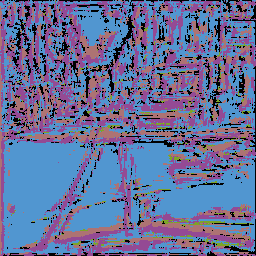

In [17]:
tf.keras.preprocessing.image.array_to_img(prediction_array_colored)

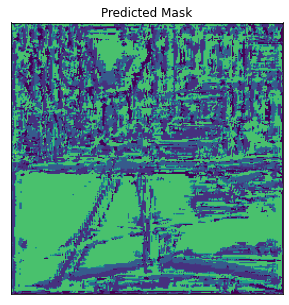

In [18]:
visualize(predicted_mask=prediction_array)

In [19]:
import requests

uri = 'http://ba61fa35-ebb3-4082-b685-591d1618b1ce.westeurope.azurecontainer.io/score'
image_path = 'aachen_000003_000019_leftImg8bit.png'
files = {'image': open(image_path, 'rb').read()}

response = requests.post(uri, files=files)

print(response.json)

<bound method Response.json of <Response [200]>>


In [20]:
prediction_array = np.array(response.json())
prediction_array_colored = cat2color(prediction_array)

In [21]:
prediction_array_colored.shape

(256, 256, 3)

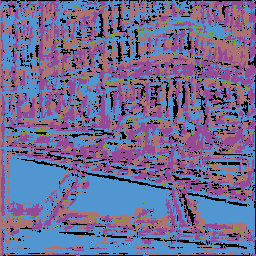

In [22]:
tf.keras.preprocessing.image.array_to_img(prediction_array_colored)

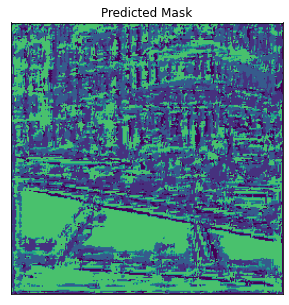

In [23]:
visualize(predicted_mask=prediction_array)